In [ ]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import r2_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

filePath = "/content/titanic.csv"

#Q1]

1]

In [ ]:
df = pd.read_csv(filePath)
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)
df = df.fillna(df.mean())
l = df.columns[df.isnull().any()].tolist()
print(l)

df = df.fillna('S')
df = df.astype({'Age': 'int32'})
lbcode = LabelEncoder()
df.Sex = lbcode.fit_transform(df.Sex)
df.Embarked = lbcode.fit_transform(df.Embarked)

#sns.pairplot(data=df, hue = 'Survived')

x= df.drop('Survived', axis = 1)                                                 #drop output from dataset and store in x
y= df.Survived                                                                   #define y as output

x_train,x_test,y_train,y_test = train_test_split(x,y,train_size  =0.7, random_state=0) #split
x_train

['Embarked']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


,Pclass,Sex,Age,Fare,Embarked
857,1,1,51,26.5500,2
52,1,0,49,76.7292,0
386,3,1,1,46.9000,2
124,1,1,54,77.2875,2
578,3,0,29,14.4583,0
...,...,...,...,...,...
835,1,0,39,83.1583,0
192,3,0,19,7.8542,2
629,3,1,29,7.7333,1
559,3,0,36,17.4000,2


2]

In [ ]:
# It was identified that the Gaussian Naive Classifier would be the best classifier in this case since it supports continuous values.
# The dataset was also observed to have continuous values in features - Age and Fare.


3]

In [ ]:
xdead = x_train[df['Survived'] == 0]
ydead = y_train[df['Survived'] == 0]
xsur = x_train[df['Survived'] == 1]
ysur = y_train[df['Survived'] == 1]

splitList = [[xdead, ydead], [xsur, ysur]]

def SumDict(d):
    sum = 0
    for i in d:
        sum+=d[i]

    return sum

def DescreteInfo(col, sur, splitList):
    tempDict = {}

    for i in splitList[sur][0][col]:
        if i in tempDict:
            tempDict[i]+=1
        else:
            tempDict[i] = 1

    return tempDict

def ContInfo(col, sur, splitList):
    return [np.mean(splitList[sur][0][col]), np.std(splitList[sur][0][col])]
           

def DescreteProb(feature, value, sur, splitList):
    d = DescreteInfo(feature, sur, splitList)
    if value not in d:
        d[value] = 1/len(x_train.index)
    return d[value] / SumDict(d)

def ContProb(feature, value, sur, splitList):
    l = ContInfo(feature, sur, splitList)
    return (1 / (np.sqrt(2 * np.pi) * l[1])) * np.exp(-((value - l[0])**2 / (2 * l[1]**2 )))

print(ContProb("Age", 32, 0, splitList))
ContProb("Age", 32, 1, splitList)

0.031462055224946


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


0.028388814183152287

In [ ]:
from sklearn.metrics import accuracy_score as acc

topClassProb = []
def Likelihood(l, sur, splitList):
    return DescreteProb('Pclass', l[0], sur, splitList) * DescreteProb('Sex', l[1], sur, splitList) * ContProb('Age', l[2], sur, splitList) * ContProb('Fare', l[3], sur, splitList) * DescreteProb('Embarked', l[4], sur, splitList)

def Predict(x_test, splitList):
    l = []
    indx = x_test.index
    for i in range(len(indx)):
        pr0 = Likelihood(x_test.loc[indx[i]], 0, splitList) * (len(splitList[0][0].index) / len(x_train.index))
        pr1 = Likelihood(x_test.loc[indx[i]], 1, splitList) * (len(splitList[1][0].index) / len(x_train.index))
        sum1 = pr1 + pr0
        pr1 = pr1 / sum1
        pr0 = pr0 / sum1

        if(pr1 > pr0):
            l.append(1)
            topClassProb.append(pr1)
        else:
            l.append(0) 
            topClassProb.append(pr0)          


    return l           


acc(y_test, Predict(x_test, splitList)) * 100

80.22388059701493

4]

In [ ]:
splitsx = np.array_split(x_train, 5)
splitsy = np.array_split(y_train, 5)
r2_scores = []


accList = []
for i in range(5):
    tempTrainx = pd.concat([splitsx[(i + 1)%5], splitsx[(i + 2)%5], splitsx[(i + 3)%5], splitsx[(i + 4)%5]], axis = 0)
    tempTestx = splitsx[i]
    tempTrainy = pd.concat([splitsy[(i + 1)%5], splitsy[(i + 2)%5], splitsy[(i + 3)%5], splitsy[(i + 4)%5]], axis = 0)
    tempTesty = splitsy[i]

    xdead = tempTrainx[tempTrainy == 0]
    ydead = tempTrainy[tempTrainy == 0]
    xsur = tempTrainx[tempTrainy == 1]
    ysur = tempTrainy[tempTrainy == 1]
    splitList = [[xdead, ydead], [xsur, ysur]]

    accList.append(acc(y_test, Predict(x_test, splitList)))           
      

5]

[0.7985074626865671, 0.7873134328358209, 0.8022388059701493, 0.8022388059701493, 0.8059701492537313]
0.7992537313432836


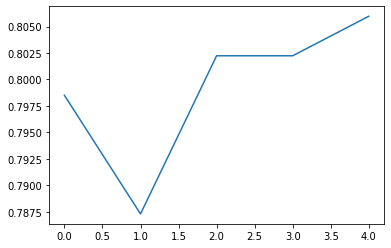

[0.898510365451413,
 0.9555980282325908,
 0.9058072172738932,
 0.999498573349399,
 0.5860197065687446,
 0.7967858979401706,
 0.9992763389227926,
 0.9997620169962562,
 0.8011079419948045,
 0.5904962704861177,
 0.9540125347361358,
 0.6122557959888222,
 0.941940660376565,
 0.7387748512740389,
 0.9725237953927596,
 0.5666807895277501,
 0.9521843229320127,
 0.8440370866715237,
 0.9578180244978975,
 0.8101723508591084,
 0.8605396911428209,
 0.9992765938513767,
 0.9419375397029889,
 0.795949671148013,
 0.6101325546639225,
 0.9985741801572502,
 0.9569119832045094,
 0.6082012901200208,
 0.6497036747956582,
 0.5350006788663147,
 0.9008366523207718,
 0.6215732709945913,
 0.9554333560749179,
 0.7870919026343159,
 0.9554940850594321,
 0.6203217729391355,
 0.9581771652708485,
 0.879321927076345,
 0.8754517199026809,
 0.880605808912,
 0.7094655724192418,
 0.8918279083816197,
 0.9563128786911231,
 0.9316289918627682,
 0.9279641577918275,
 0.9556651559548811,
 0.9556651559548811,
 0.9999999997173513,
 

In [ ]:
print(accList)
print(np.mean(accList))
plt.plot(range(5), accList)
plt.show()

topClassProb


6]

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

gnb = GaussianNB()
gnb.fit(x_train,y_train)
y_pred = gnb.predict(x_test)

print("Accuracy for Inbuilt model:", metrics.accuracy_score(y_test, y_pred)*100 , "%")
print("Accuracy for from-scratch model", acc(y_test, Predict(x_test, splitList)) * 100,"%")

Accuracy for Inbuilt model: 78.35820895522389 %
Accuracy for from-scratch model 80.59701492537313 %


7]

In [ ]:
from sklearn.tree import DecisionTreeRegressor

splitsx = np.array_split(x_train, 5)
splitsy = np.array_split(y_train, 5)
r2_scores = []


accList = []
for i in range(5):
    tempacc = []
    tempTrainx = pd.concat([splitsx[(i + 1)%5], splitsx[(i + 2)%5], splitsx[(i + 3)%5], splitsx[(i + 4)%5]], axis = 0)
    tempTestx = splitsx[i]
    tempTrainy = pd.concat([splitsy[(i + 1)%5], splitsy[(i + 2)%5], splitsy[(i + 3)%5], splitsy[(i + 4)%5]], axis = 0)
    tempTesty = splitsy[i]

    model = DecisionTreeRegressor()
    model.fit(tempTrainx, tempTrainy)
    accList.append(acc( tempTesty, model.predict(tempTestx).round()))

print("Accuracy for KFold model:", (np.mean(accList) * 100))
print("Accuracy for from-scratch model:", acc(y_test, Predict(x_test, splitList)) * 100,"%")

Accuracy for KFold model: 76.56258064516129
Accuracy for from-scratch model: 80.59701492537313 %


#Q2]

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter


1]

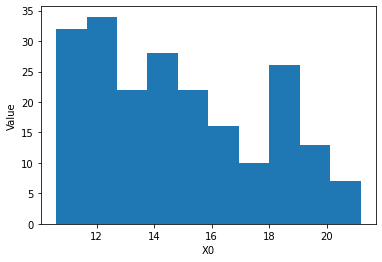

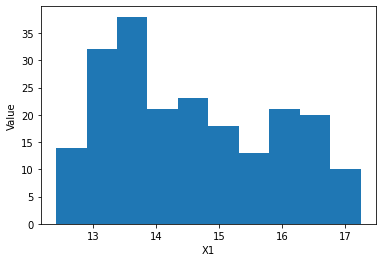

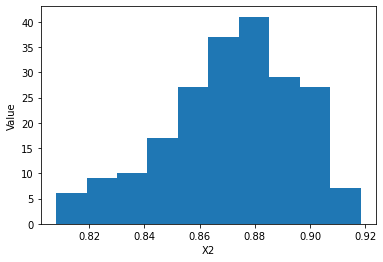

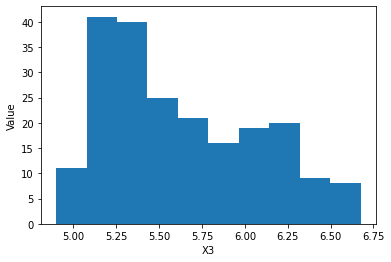

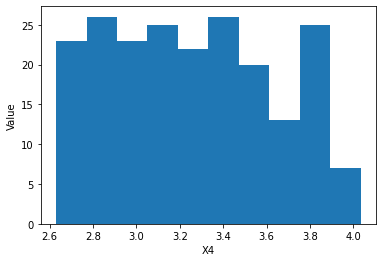

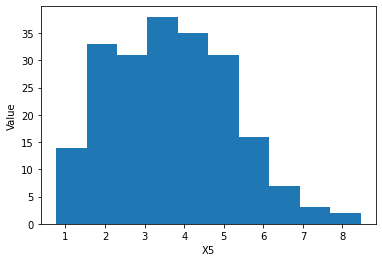

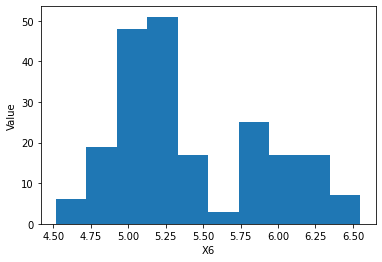

In [ ]:
filePath = "/content/dataset.csv"
df = pd.read_csv(filePath)
df

for i in df.columns:
    if(i == "Y"):
        continue
    l = df[i].tolist()
    fig, ax = plt.subplots(1, 1)
    ax.hist(l)    
    ax.set_xlabel(i)
    ax.set_ylabel('Value')
    plt.show()


2]

In [ ]:
count1 = count2 = count3 = 0
for i in df.Y:
    if(i == 1):
        count1+=1
    elif(i == 2):
        count2+=1
    else:
        count3+=1

print("Prior Probablility of Case 1:", count1/len(df.Y))
print("Prior Probablility of Case 2:", count2/len(df.Y))
print("Prior Probablility of Case 3:", count3/len(df.Y))

Prior Probablility of Case 1: 0.3333333333333333
Prior Probablility of Case 2: 0.3333333333333333
Prior Probablility of Case 3: 0.3333333333333333


3]

In [ ]:
def Discretize(col, n_bin):
    temp = df[col].tolist()
    minTemp = min(temp)
    dif = (max(temp) - minTemp) / n_bin

    for i in range(len(df[col])):
        for j in range(1 , n_bin+1):
            if(df[col][i] <= minTemp + j*dif):
                df[col][i] = j-1
                break

for i in df.columns:
    if(i == 'Y'):
        continue
    Discretize(i, 10)

df = df.astype('int32')
df


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,X0,X1,X2,X3,X4,X5,X6,Y
0,4,5,5,4,4,1,3,1
1,4,4,6,3,5,0,2,1
2,3,3,8,2,5,2,1,1
3,3,3,7,2,5,1,1,1
4,5,5,8,4,6,0,3,1
...,...,...,...,...,...,...,...,...
205,1,1,6,1,2,3,1,3
206,0,0,3,1,1,4,2,3
207,2,2,7,1,4,9,2,3
208,1,1,3,1,1,3,2,3


4]

In [ ]:
listdf = []
listdf.append(df[df.Y == 1])
listdf.append(df[df.Y == 2])
listdf.append(df[df.Y == 3])

def SumDict(d):
    sum = 0
    for i in d:
        sum+=d[i]

    return sum

def GetInfo(df, col):
    d = {}
    for i in df[col]:
        if i in d:
            d[i]+=1
        else:
            d[i] = 1
    return d

def GetLH(df, Class, col):
    tempdf = listdf[Class - 1]
    d = GetInfo(tempdf, col)
    sum = SumDict(d)
    for i in d:
        d[i] = d[i] / sum
    return d


def PrintLH(df):
    for i in range(1,4):
        print()
        print("Class", i)
        for j in df.columns:
            if(j == 'Y'):
                continue
            print("Column", j)
            print(GetLH(df, i, j))

PrintLH(df)
data = df.to_numpy()




Class 1
Column X0
{4: 0.24285714285714285, 3: 0.4, 5: 0.08571428571428572, 2: 0.18571428571428572, 1: 0.04285714285714286, 6: 0.014285714285714285, 0: 0.02857142857142857}
Column X1
{5: 0.15714285714285714, 4: 0.3142857142857143, 3: 0.2571428571428571, 6: 0.02857142857142857, 2: 0.18571428571428572, 1: 0.02857142857142857, 0: 0.02857142857142857}
Column X2
{5: 0.2571428571428571, 6: 0.2571428571428571, 8: 0.12857142857142856, 7: 0.18571428571428572, 9: 0.04285714285714286, 4: 0.1, 2: 0.014285714285714285, 3: 0.014285714285714285}
Column X3
{4: 0.2571428571428571, 3: 0.2714285714285714, 2: 0.22857142857142856, 6: 0.014285714285714285, 5: 0.08571428571428572, 1: 0.1, 0: 0.04285714285714286}
Column X4
{4: 0.2571428571428571, 5: 0.2571428571428571, 6: 0.07142857142857142, 3: 0.24285714285714285, 2: 0.11428571428571428, 7: 0.014285714285714285, 1: 0.04285714285714286}
Column X5
{1: 0.2571428571428571, 0: 0.18571428571428572, 2: 0.24285714285714285, 3: 0.14285714285714285, 4: 0.114285714285

5]


Class 1
Column X0 Class 1


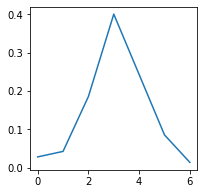

Column X1 Class 1


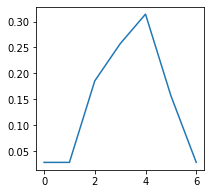

Column X2 Class 1


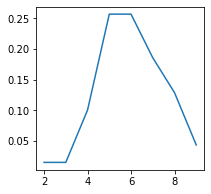

Column X3 Class 1


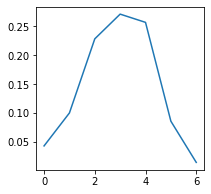

Column X4 Class 1


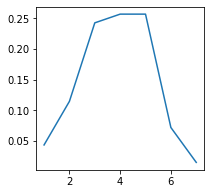

Column X5 Class 1


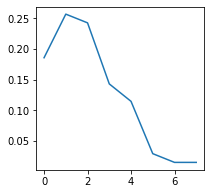

Column X6 Class 1


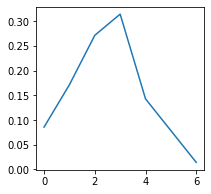


Class 2
Column X0 Class 2


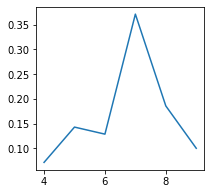

Column X1 Class 2


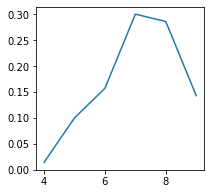

Column X2 Class 2


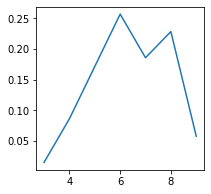

Column X3 Class 2


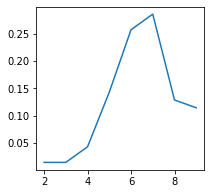

Column X4 Class 2


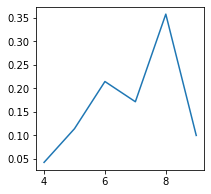

Column X5 Class 2


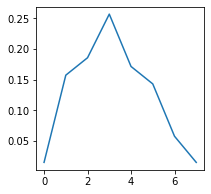

Column X6 Class 2


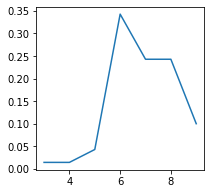


Class 3
Column X0 Class 3


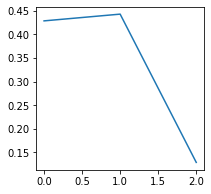

Column X1 Class 3


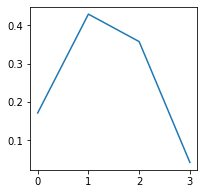

Column X2 Class 3


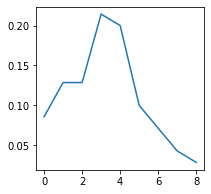

Column X3 Class 3


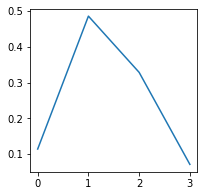

Column X4 Class 3


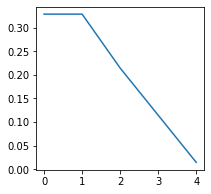

Column X5 Class 3


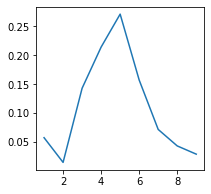

Column X6 Class 3


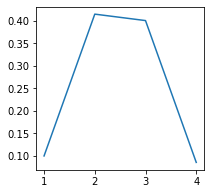

In [ ]:
from collections import OrderedDict

def PlotLH(df):
    for i in range(1,4):
        print()
        print("Class", i)
        for j in df.columns:
            if(j == 'Y'):
                continue
            print("Column", j, "Class", i)
            d = (GetLH(df, i, j))
            d = OrderedDict(sorted(d.items()))
            plt.figure(figsize=(3, 3))
            plt.plot(list(d.keys()), list(d.values()))
            plt.show()

PlotLH(df)

6]

In [ ]:
print(df)
x = df.drop(['Y'], axis = 1)
y = df.Y

x_train,x_test,y_train,y_test = train_test_split(x,y,train_size  =0.7, random_state=0)
x_train

x1 = x_train[df['Y'] == 1]
y1 = y_train[df['Y'] == 1]
x2 = x_train[df['Y'] == 2]
y2 = y_train[df['Y'] == 2]
x3 = x_train[df['Y'] == 3]
y3 = y_train[df['Y'] == 3]
splitList = [[x1, y1], [x2, y2], [x3, y3]]

plotList = []

def Likelihood2(l, Class, splitList):
    ans = 1
    for i in range(len(l)):
        col = "X" + str(i)
        ans *= DescreteProb(col, l[i], Class, splitList)

    return ans

def Predict2(x_test, splitList):
    l = []
    indx = x_test.index
    for i in range(len(indx)):
        pr0 = Likelihood2(x_test.loc[indx[i]], 0, splitList) * (len(splitList[0][0].index) / len(x_train.index))
        pr1 = Likelihood2(x_test.loc[indx[i]], 1, splitList) * (len(splitList[1][0].index) / len(x_train.index))
        pr2 = Likelihood2(x_test.loc[indx[i]], 2, splitList) * (len(splitList[2][0].index) / len(x_train.index))
        sum1 = pr1 + pr0 + pr2
        pr2 = pr2 / sum1
        pr1 = pr1 / sum1
        pr0 = pr0 / sum1
        plotList.append([pr0, pr1, pr2])
        print(len(plotList), end=" ")

        if(pr1 > pr0 and pr1 > pr2):
            l.append(2)
        elif(pr2 > pr0):
            l.append(3)
        else:
            l.append(1)


    return l

print(len(x_test.index))
print(acc(y_test, Predict2(x_test, splitList)))
print(y_test.tolist())

     X0  X1  X2  X3  X4  X5  X6  Y
0     4   5   5   4   4   1   3  1
1     4   4   6   3   5   0   2  1
2     3   3   8   2   5   2   1  1
3     3   3   7   2   5   1   1  1
4     5   5   8   4   6   0   3  1
..   ..  ..  ..  ..  ..  ..  .. ..
205   1   1   6   1   2   3   1  3
206   0   0   3   1   1   4   2  3
207   2   2   7   1   4   9   2  3
208   1   1   3   1   1   3   2  3
209   1   1   5   1   2   6   2  3

[210 rows x 8 columns]
63
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 0.9047619047619048
[1, 2, 1, 1, 3, 2, 2, 2, 2, 3, 1, 3, 1, 3, 2, 2, 3, 1, 1, 1, 3, 1, 1, 1, 2, 2, 2, 2, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2, 1, 2, 3, 1, 2, 3, 1, 2, 2, 1, 1, 2, 1, 2, 3, 3, 1, 1, 2, 2, 2, 2, 3, 2, 2]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


63


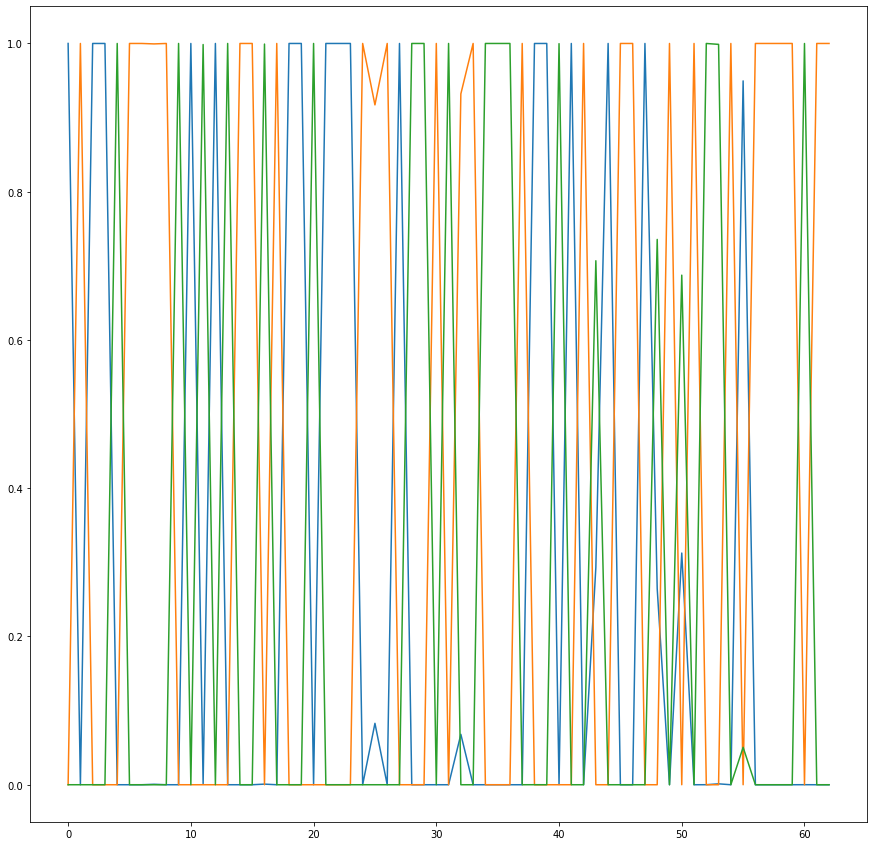

In [ ]:
l0 = []
l1 = []
l2 = []
for i in plotList:
    l0.append(i[0])
    l1.append(i[1])
    l2.append(i[2])

print(len(plotList))
plt.figure(figsize=(15, 15))
plt.plot(range(len(plotList)), l0)
plt.plot(range(len(plotList)), l1)
plt.plot(range(len(plotList)), l2)
plt.show()